In [2]:
from __future__ import print_function
import os
import cv2
import h5py
import numpy as np
from copy import deepcopy
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Functions

In [3]:
def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])

def get_bbox(index, hdf5_data):
    all_iterm_data = []
    item = hdf5_data['digitStruct']['bbox'][index].item()
    for key in ['label', 'left', 'top', 'width', 'height']:
        attr = hdf5_data[item][key]
        values = [hdf5_data[attr.value[i].item()].value[0][0]
                  for i in range(len(attr))] if len(attr) > 1 else [attr.value[0][0]]
        all_iterm_data.append(values)

    return all_iterm_data

def biggest_box(all_data, sample_index, total_samples):
    all_left  = []
    all_top   = []
    all_width = []
    all_heigt = []

    for k in range(total_samples):
        sample_left  = abs(int(all_data[sample_index][1][1][k]))
        sample_top   = abs(int(all_data[sample_index][1][2][k]))
        sample_width = abs(int(all_data[sample_index][1][3][k]))
        sample_heigt = abs(int(all_data[sample_index][1][4][k]))

        all_left.append(sample_left)
        all_top.append(sample_top)
        all_width.append(sample_left+sample_width)
        all_heigt.append(sample_top+sample_heigt)

    low_left = min(all_left)
    low_top  = min(all_top)
    highest_width = max(all_width) - low_left
    highest_height = max(all_heigt) - low_top

    return low_left, low_top, highest_width, highest_height

### Main

In [4]:
#----------------------------Arguments---------------------------------------
dataset_type     = 'test' # Change to train/test
dataset_dir      = './dataset'
curated_dataset  = os.path.join(dataset_dir, dataset_type + '_cropped')
curated_textfile = os.path.join(dataset_dir, dataset_type + '.txt')
file_path        = './dataset/%s/' % (dataset_type)
mat_file         = './dataset/%s/digitStruct.mat' % (dataset_type)
expand_percent   = 30
img_size         = (64, 64) # (width, height)
max_steps        = 5

if os.path.exists(curated_dataset) == False:
    os.mkdir(curated_dataset)

In [5]:
ground_attention_downsample = (7, 7)

In [6]:
expand_percent = expand_percent/100.0
print(expand_percent)

0.3


In [7]:
f = h5py.File(mat_file,'r')
print('Total bboxes: ', f['/digitStruct/name'].shape[0])

all_data = []
#for j in range(f['/digitStruct/bbox'].shape[0]):
for j in range(1000):
    img_name = get_name(j, f)
    row_dict = get_bbox(j, f)

    all_data.append([img_name, row_dict])

    if j%500 == 0:
        print('Completion..{%d/%d}' % (j, f['/digitStruct/bbox'].shape[0]))

print('Completion..{%d/%d}' % (f['/digitStruct/bbox'].shape[0], f['/digitStruct/bbox'].shape[0]))
print('Completed!')

Total bboxes:  13068
Completion..{0/13068}
Completion..{500/13068}
Completion..{13068/13068}
Completed!


In [8]:
# Create copy of samples to curate labels
all_data_copy = deepcopy(all_data)

### Visualize

In [34]:
sample_index = 875

In [35]:
sample_imgph = all_data[sample_index][0]
sample_image = cv2.imread(file_path+sample_imgph)
sample_image_copy = deepcopy(sample_image)
sample_heigt_org, sample_width_org, _ = sample_image.shape
# Get how many digits:
total_samples = np.array(all_data[sample_index][1]).shape[1]
print('Path:', file_path+sample_imgph)

Path: ./dataset/test/876.png


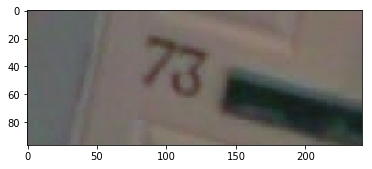

In [36]:
plt.imshow(sample_image)
plt.show()

In [37]:
#-------------------------------------------------------------------
## Get bounding box encompassing all digits
low_left, low_top, high_width, high_height = biggest_box(all_data=all_data,\
                      sample_index=sample_index, total_samples=total_samples)

(-0.5, 240.5, 96.5, -0.5)

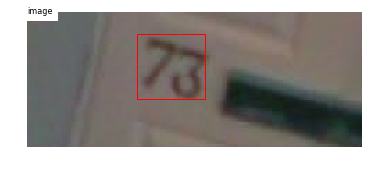

In [38]:
fig,ax = plt.subplots(1, 1)
ax.text(0, 1, 'image', color='black', backgroundcolor='white', fontsize=8)
ax.imshow(sample_image)
rect = patches.Rectangle((low_left, low_top), high_width, high_height,\
                         linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.axis('off')

In [39]:
def check_low_extend(check_ex):
    if check_ex < 0:
        return 0
    else:
        return check_ex

def check_high_extend(check_ex, low_ex, orgsample_dim):
    if (low_ex + check_ex) > orgsample_dim:
        delta = (low_ex + check_ex) - orgsample_dim
        return check_ex - delta
    else:
        return check_ex        

In [40]:
#-------------------------------------------------------------------
## Crop
# Obtain the spatial extend to crop
low_x  = low_left - int(expand_percent * low_left)
low_x  = check_low_extend(check_ex=low_x)

low_y  = low_top  - int(expand_percent * low_top)
low_y  = check_low_extend(check_ex=low_y)

high_x = high_width  + int(expand_percent * high_width)
high_x = check_high_extend(check_ex=high_x, low_ex=low_x,\
                              orgsample_dim=sample_width_org)

high_y = high_height + int(expand_percent * high_height)
high_y = check_high_extend(check_ex=high_y, low_ex=low_y,\
                              orgsample_dim=sample_heigt_org)

In [41]:
print(low_left, low_top, high_width, high_height)

79 15 49 47


In [42]:
print(low_x, low_y, high_x, high_y)

56 11 63 61


In [43]:
#------- X-axis shift -------
if low_x > 0:
    sample_image_copy = sample_image_copy[:, low_x:, :]
    # Update
    for i in range(total_samples):
        # Update lower bound-- left
        all_data_copy[sample_index][1][1][i] -= low_x
        
if high_x < sample_width_org:
    sample_image_copy = sample_image_copy[:, :(low_x+high_x), :]

#------- Y-axis shift-------
if low_y > 0:
    sample_image_copy = sample_image_copy[low_y:, :, :]
    # Include fixed pixels from all upper bound-- top
    for i in range(total_samples):
        all_data_copy[sample_index][1][2][i] -= low_y

if high_y < sample_heigt_org:
    sample_image_copy = sample_image_copy[:(low_y+high_y), :, :]

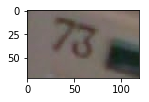

In [44]:
plt.figure(figsize=(2, 2))
plt.imshow(sample_image_copy)
plt.show()

In [45]:
#-------------------------------------------------------------------
## Get bounding box encompassing all digits
low_left, low_top, high_width, high_height = biggest_box(all_data=all_data_copy,\
                      sample_index=sample_index, total_samples=total_samples)

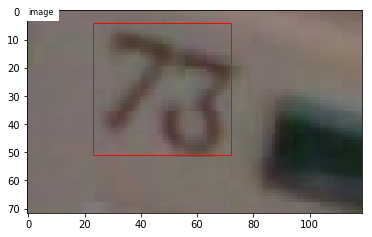

In [46]:
fig,ax = plt.subplots(1, 1)
ax.text(0, 1, 'image', color='black', backgroundcolor='white', fontsize=8)
ax.imshow(sample_image_copy)
rect = patches.Rectangle((low_left, low_top), high_width, high_height,\
                         linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

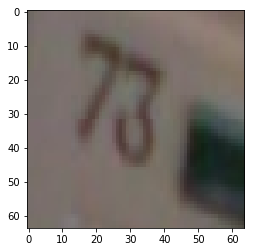

In [47]:
## Resize image
sample_heigt_org_rz, sample_width_org_rz, _ = sample_image_copy.shape

if sample_width_org_rz > img_size[0]:
    # Shrinking
    smpl_img_rz = cv2.resize(sample_image_copy, img_size, interpolation = cv2.INTER_AREA)
else:
    # Zooming
    smpl_img_rz = cv2.resize(sample_image_copy, img_size, interpolation = cv2.INTER_LINEAR)

plt.imshow(smpl_img_rz)

### Curate labels to match new image shape

In [48]:
# Collect samples
samples = []

for index_into in range(max_steps):
    if index_into > total_samples - 1:
        sample_label = 0
        sample_left  = 0
        sample_top   = 0
        sample_width = 0
        sample_heigt = 0

    else:
        sample_label = int(all_data_copy[sample_index][1][0][index_into])
        sample_left  = abs(int((all_data_copy[sample_index][1][1][index_into] * img_size[0])/sample_width_org_rz))
        sample_top   = abs(int((all_data_copy[sample_index][1][2][index_into] * img_size[1])/sample_heigt_org_rz))
        sample_width = abs(int((all_data_copy[sample_index][1][3][index_into] * img_size[0])/sample_width_org_rz))
        sample_heigt = abs(int((all_data_copy[sample_index][1][4][index_into] * img_size[1])/sample_heigt_org_rz))

    # Append
    samples.append([all_data_copy[sample_index][0][:-4], sample_label, sample_left, sample_top, sample_width, sample_heigt])

In [49]:
samples

[['876', 7, 12, 3, 15, 39],
 ['876', 3, 24, 6, 14, 39],
 ['876', 0, 0, 0, 0, 0],
 ['876', 0, 0, 0, 0, 0],
 ['876', 0, 0, 0, 0, 0]]

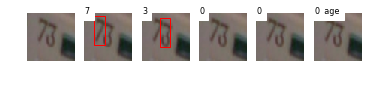

In [50]:
fig,ax = plt.subplots(1, max_steps+1)
plt.text(0, 1, 'image', color='black', backgroundcolor='white', fontsize=8)
ax[0].imshow(smpl_img_rz)
ax[0].axis('off')
        
for k in range(max_steps):
    sample_label = samples[k][1]
    sample_left  = samples[k][2]
    sample_top   = samples[k][3]
    sample_width = samples[k][4]
    sample_heigt = samples[k][5]
    
    rect = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,\
                             linewidth=1, edgecolor='r', facecolor='none')  
    ax[k+1].text(0, 1, sample_label, color='black', backgroundcolor='white', fontsize=8)
    ax[k+1].imshow(smpl_img_rz)
    ax[k+1].add_patch(rect)
    ax[k+1].axis('off')

### Extra: check attention on the resized

In [51]:
def gaussian2d(sup, scales):
    """
    Creates a 2D Gaussian based on the size and scale.
    """
    var   = scales * scales
    shape = (sup[0], sup[1])
    n,m   = [(i-1)/2 for i in shape]
    y,x   = np.ogrid[-m:m+1,-n:n+1]
    
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var))

    return g

In [52]:
def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    """
    e_x = np.exp(x - np.max(x))

    return e_x / e_x.sum(axis=0)

def generate_ground_gaussian_attention_mask(sample, sample_top, sample_height, sample_left, sample_width):
    """
    Creates a ground truth attention mask based on ground truth bounding boxes,
    and scales to fit into the box.
    """
    sample_image_height, sample_image_width, _ = sample.shape 
    scales = np.sqrt(2) * 8 # Play with the standard deviation
    
    # Convert even to odd by adding extra px
    if sample_width%2 == 0:
        sample_width += 1
    
    if sample_height%2 == 0:
        sample_height += 1
    
    gaussain = gaussian2d((sample_width, sample_height), scales)
    gaussain_normalized = (gaussain - np.min(gaussain))/\
                          (np.max(gaussain) - np.min(gaussain))

    sample_attention = np.zeros((sample_image_height, sample_image_width)) * 0.0
    
    sample_attention[sample_top:sample_top+sample_height, sample_left:sample_left+sample_width] = gaussain_normalized

    sample_attention_res  = cv2.resize(sample_attention, ground_attention_downsample, interpolation=cv2.INTER_NEAREST)

    sample_attention_res  = sample_attention_res.flatten()

    sample_attention_res_norm = softmax(sample_attention_res)
    sample_attention_res_norm = np.reshape(sample_attention_res_norm, ground_attention_downsample)

    return sample_attention, sample_attention_res_norm

In [53]:
def biggest_box1(samples):
    all_left  = []
    all_top   = []
    all_width = []
    all_heigt = []

    for k in range(total_samples):
        sample_label = samples[k][1]
        sample_left  = samples[k][2]
        sample_top   = samples[k][3]
        sample_width = samples[k][4]
        sample_heigt = samples[k][5]

        all_left.append(sample_left)
        all_top.append(sample_top)
        all_width.append(sample_left+sample_width)
        all_heigt.append(sample_top+sample_heigt)

    low_left = min(all_left)
    low_top  = min(all_top)
    highest_width = max(all_width) - low_left
    highest_height = max(all_heigt) - low_top
    
    return low_left, low_top, highest_width, highest_height

In [54]:
def generate_stop_attention_mask(samples, sample_image):
    sample_image_height, sample_image_width, _ = sample_image.shape
    
    low_left, low_top, highest_width, highest_height = biggest_box1(samples)
    
    x = np.ones((sample_image_height, sample_image_width))
    
    mask = np.ones((sample_image_height, sample_image_width))
    
    mask[low_top:low_top+highest_height, low_left:low_left+highest_width] = 0
    
    x2 = np.multiply(x, mask)
    
    x3 = softmax(x2.flatten())
    
    x3 = np.reshape(x3, (sample_image_height, sample_image_width))
    
    return x3

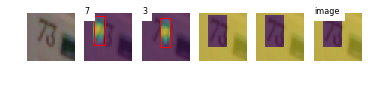

In [55]:
fig,ax = plt.subplots(1, max_steps+1)
plt.text(0, 1, 'image', color='black', backgroundcolor='white', fontsize=8)
ax[0].imshow(smpl_img_rz)
ax[0].axis('off')
        
for k in range(max_steps):
    if k > total_samples - 1:
        sample_label = samples[k][1]
        sample_left  = samples[k][2]
        sample_top   = samples[k][3]
        sample_width = samples[k][4]
        sample_heigt = samples[k][5]
        
        stop_mask = generate_stop_attention_mask(samples, sample_image=smpl_img_rz)
        ax[k+1].imshow(smpl_img_rz)
        ax[k+1].imshow(stop_mask, alpha=0.5)
        ax[k+1].axis('off')
    else:
        sample_label = samples[k][1]
        sample_left  = samples[k][2]
        sample_top   = samples[k][3]
        sample_width = samples[k][4]
        sample_heigt = samples[k][5]

        acc, get_attention_mask = generate_ground_gaussian_attention_mask(smpl_img_rz,\
                                        sample_top, sample_heigt, sample_left, sample_width)
        #sample_attention_res = skimage.transform.pyramid_expand(get_attention_mask, upscale=9.1, sigma=1)
        #print(sample_attention_res)
        rect = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,\
                                  linewidth=1, edgecolor='r', facecolor='none')  
        ax[k+1].text(0, 1, sample_label, color='black', backgroundcolor='white', fontsize=8)
        ax[k+1].imshow(smpl_img_rz)
        ax[k+1].imshow(acc, alpha=0.5)
        ax[k+1].add_patch(rect)
        ax[k+1].axis('off')